# HyDRA

(Hybrid Deep learning models for Rapid Assesments)

This notebook provides an example on how to train and evaluate a HyDRA model.  

### Libraries

In [1]:
from utils.models import build_hydra,mae_loss,agg_Y,eval_r
from utils.DataGenerators import DataGenerator
import matplotlib.pyplot as plt
import time
import multiprocessing
import numpy as np
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

### Data generators

In [2]:
features='MW' # Put the desired feature set
Data_dir='../Data' # Replace with the path of the main dataset directory for all folds
fold_id=1          # A value between 1-6

In [3]:
train_generator=DataGenerator(Data_dir,'train',fold_id,features,shuffle=True)
val_generator=DataGenerator(Data_dir,'val',fold_id,features,shuffle=False)
test_generator=DataGenerator(Data_dir,'test',fold_id,features,shuffle=False)

Checking the generator data:

In [4]:
sample_input,sample_label = val_generator.__getitem__(0)
print('Input tesnors: ')
for X_i in sample_input:
    print(X_i.shape)
print('Label tensors: ')
print(sample_label.shape)
print('n_batch: %d'%(train_generator.__len__()))

Input tesnors: 
(1436, 400, 48)
(1436, 400, 48)
Label tensors: 
(1436, 1)
n_batch: 215


### Visualizing sample MFB and W feature tesnors

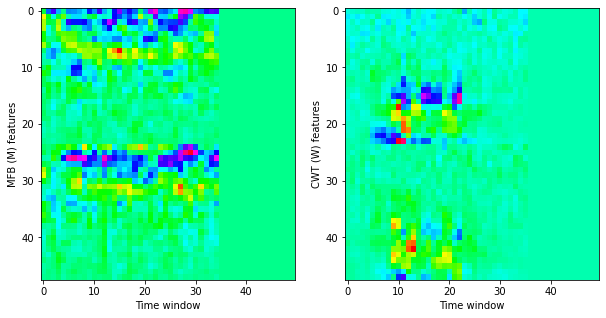

In [5]:
batch_obs_indx=6 # observation index inside each batch
max_frame_indx=50 # last window indx in the plots
fig,ax=plt.subplots(1,2,figsize=(10,5))
if 'M' in features:
    ax[0].imshow(sample_input[0][batch_obs_indx,0:max_frame_indx].swapaxes(0,1),aspect='auto',cmap='hsv')
    ax[0].set_xlabel('Time window')
    ax[0].set_ylabel('MFB (M) features')
else:
    ax[0].set_axis_off()
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
if 'W' in features:
    ax[1].imshow(sample_input[1][batch_obs_indx,0:max_frame_indx].swapaxes(0,1),aspect='auto',cmap='hsv')
    ax[1].set_xlabel('Time window')
    ax[1].set_ylabel('CWT (W) features')
else:
    ax[1].set_axis_off()
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)
plt.show()
plt.close()

### Building the HyDRA model
A tensorflow model object can be created by passing the hydra_id (e.g, 'M','MZ','WZ',...) to `build_hydra`. You can access to the function's documentation by pressing `shift`+`tab` twice in the following cell.

In [6]:
model_HyDRA=build_hydra(features,show_model_summary=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 48)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 48)]   0           []                               
                                                                                                  
 masking (Masking)              (None, None, 48)     0           ['input_1[0][0]']                
                                                                                                  
 masking_1 (Masking)            (None, None, 48)     0           ['input_2[0][0]']                
                                                                                              

### Training

In [7]:
n_epoch=10
patience=20
model_filename_save='example_'+features+'_model.h5'
verbose=1
# The following parameters will affect how fast your model is trained
n_workers=multiprocessing.cpu_count() # adjust based on your cpu specs
max_queue_size=10                      # adjust based on your cpu, ram and gpu specs

In [8]:
model_HyDRA.compile(optimizer='Nadam', loss='mae',metrics=[mae_loss])

model_callbacks = [EarlyStopping(monitor='val_loss', patience=patience),
         ModelCheckpoint(filepath=model_filename_save,
                         monitor='val_mae_loss', save_best_only=True,mode='min')]  #plot_losses

start_time = time.time()

model_hist = model_HyDRA.fit(train_generator,epochs=n_epoch,verbose=verbose,
                           callbacks=model_callbacks,
                           validation_data=val_generator,
                           workers=n_workers,
                           max_queue_size=max_queue_size)
end_time = time.time()  

train_dur=end_time-start_time

print('training took %1.1f seconds or %1.2f minutes'%(train_dur, train_dur/60))

# Loss log plot      
train_loss=model_hist.history['loss']
val_loss=model_hist.history['val_loss']
train_loss_pure=model_hist.history['mae_loss']
val_loss_pure=model_hist.history['val_mae_loss']

Epoch 1/10
215/215 [==============================] - 39s 128ms/step - loss: 0.2955 - mae_loss: 0.1693 - val_loss: 0.2343 - val_mae_loss: 0.1190
Epoch 2/10
215/215 [==============================] - 24s 109ms/step - loss: 0.1750 - mae_loss: 0.0701 - val_loss: 0.1553 - val_mae_loss: 0.0607
Epoch 3/10
215/215 [==============================] - 23s 104ms/step - loss: 0.1398 - mae_loss: 0.0546 - val_loss: 0.1336 - val_mae_loss: 0.0574
Epoch 4/10
215/215 [==============================] - 24s 108ms/step - loss: 0.1173 - mae_loss: 0.0491 - val_loss: 0.1148 - val_mae_loss: 0.0542
Epoch 5/10
215/215 [==============================] - 24s 110ms/step - loss: 0.0986 - mae_loss: 0.0444 - val_loss: 0.1106 - val_mae_loss: 0.0624
Epoch 6/10
215/215 [==============================] - 24s 111ms/step - loss: 0.0835 - mae_loss: 0.0406 - val_loss: 0.0932 - val_mae_loss: 0.0552
Epoch 7/10
215/215 [==============================] - 24s 111ms/step - loss: 0.0716 - mae_loss: 0.0377 - val_loss: 0.0823 - val_ma

## Evaluation

In [9]:
normFact=0.075
Drift_limit=normFact

best_model=load_model(model_filename_save,custom_objects={'mae_loss': mae_loss})

Y_pred_val=best_model.predict(val_generator)*normFact
Y_pred_test=best_model.predict(test_generator)*normFact

Y_val_opt=agg_Y(val_generator)
Y_test_opt=agg_Y(test_generator)

Y_val_opt=Y_val_opt*normFact
Y_test_opt=Y_test_opt*normFact

MAE_val,MSE_val=eval_r(Y_val_opt,Y_pred_val)
MAE_test,MSE_test=eval_r(Y_test_opt,Y_pred_test)

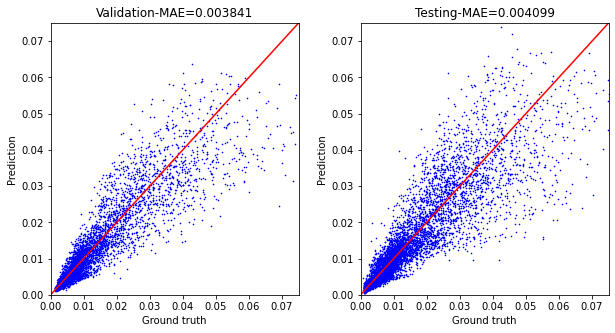

In [10]:
# Regression plots
fig,ax=plt.subplots(1,2,figsize=(10,5))

plt.subplots_adjust(wspace=0.25, hspace=0)

ax[0].plot(Y_val_opt,Y_pred_val,'bx',markersize=1)
ax[0].plot([0,1],[0,1],'-r')
ax[0].set_xlim(0,Drift_limit)
ax[0].set_ylim(0,Drift_limit)
ax[0].set_title('Validation-MAE='+str(np.round(MAE_val,6)))

ax[1].plot(Y_test_opt,Y_pred_test,'bx',markersize=1)
ax[1].plot([0,1],[0,1],'-r')
ax[1].set_xlim(0,Drift_limit)
ax[1].set_ylim(0,Drift_limit)
ax[1].set_title('Testing-MAE='+str(np.round(MAE_test,6)))

for i in range(2):
    ax[i].set_xlabel('Ground truth')
    ax[i].set_ylabel('Prediction')
plt.show()
plt.close()